## NLP Disaster Tweets Kaggle Mini-Project


For my assignment, I will be developing a Natural Language Processing (NLP) model to address the challenge posed by the "NLP Getting Started" Kaggle competition. The objective is to classify tweets as being about real disasters (labeled as 1) or not (labeled as 0). NLP, a key area of Artificial Intelligence (AI), enables the processing and understanding of human language to extract meaningful insights and make predictions. The dataset comprises a training set of 7,613 tweets with id, keyword, location, text, and target columns, as well as a test set of 3,263 tweets without the target column. The primary focus will be on the text column, which contains unstructured tweets filled with URLs, hashtags, and emojis, necessitating comprehensive preprocessing. Additionally, the keyword and location columns, though potentially informative, are sparse and require careful handling. My approach will involve data exploration, text cleaning, and feature engineering, followed by model development and evaluation to effectively predict disaster-related tweets. Finally, I will generate predictions for the test set to demonstrate the application of my model in solving this real-world problem.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## Dataset
1. id: Unique identifier for each tweet.
2. text: The tweet content.
3. location: User-specified location (may be sparse or inconsistent).
4. keyword: Disaster-related keyword from the tweet (if any).
5. target: Label indicating whether the tweet is about a real disaster (1) or not (0). Present only in train.csv.

The goal of the competition is to predict the target label for each tweet in the test set based on the text, location, and keyword information provided. Participants are evaluated based on the F1 score, which balances the precision and recall of the model's predictions. The format for submission includes:

1. id: The tweet identifier, matching those in the test.csv file.
2. target: A column where participants will fill in their predicted labels for each tweet in the test set, with 1 indicating a disaster-related tweet and 0 indicating otherwise.

In [5]:
# Load the datasets
train_path = "data/train.csv"
test_path = "data/test.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

print("Loading the datasets...")

Loading the datasets...


## Exploratory Data Analysis (EDA)

In [58]:
print(train_data.head())
print(test_data.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  text_length                                       cleaned_text  
0       1           69  our deeds are the reason of this earthquake ma...  
1       1           38              forest fire near la ronge sask canada  
2       1          133  all residents asked to shelter in place are be...  
3       1           65  13000 people receive wildfires evacuation orde...  
4       1           88  just got sent this photo from ruby alaska as s...  
   id keyword location                                               text  \
0   

In [10]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7613 non-null   int64 
 1   keyword      7552 non-null   object
 2   location     5080 non-null   object
 3   text         7613 non-null   object
 4   target       7613 non-null   int64 
 5   text_length  7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB


In [12]:
target_counts = train_data['target'].value_counts()
print(target_counts)

target
0    4342
1    3271
Name: count, dtype: int64


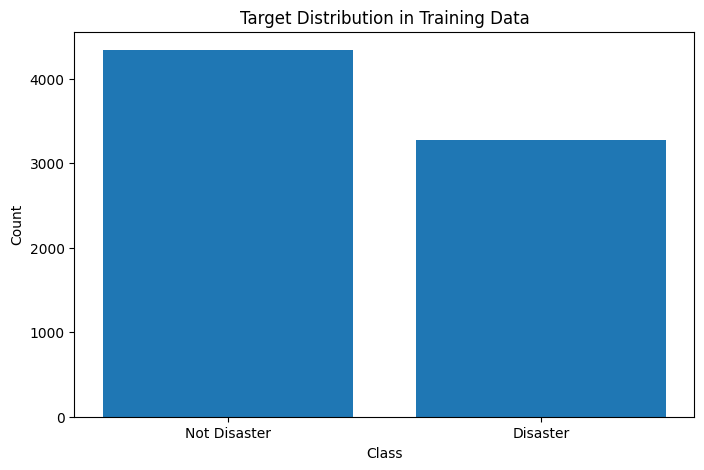

In [13]:
plt.figure(figsize=(8, 5))
plt.bar(target_counts.index, target_counts.values, tick_label=["Not Disaster", "Disaster"])
plt.title("Target Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [14]:
missing_values = train_data.isnull().sum()


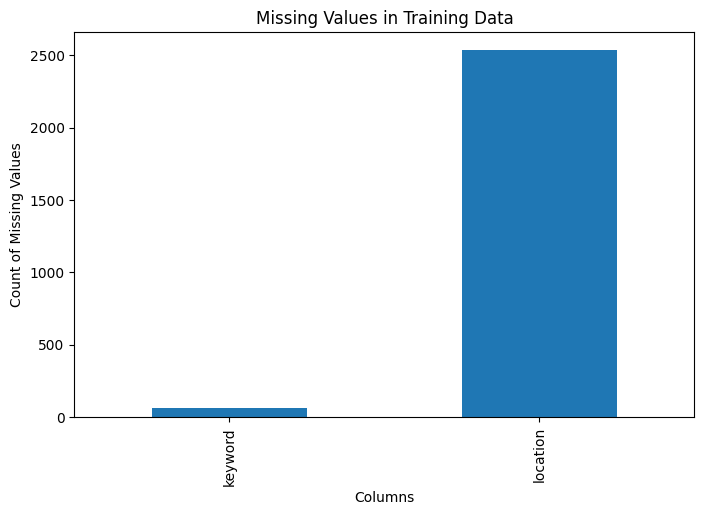

In [15]:
plt.figure(figsize=(8, 5))
missing_values[missing_values > 0].plot(kind='bar')
plt.title("Missing Values in Training Data")
plt.xlabel("Columns")
plt.ylabel("Count of Missing Values")
plt.show()

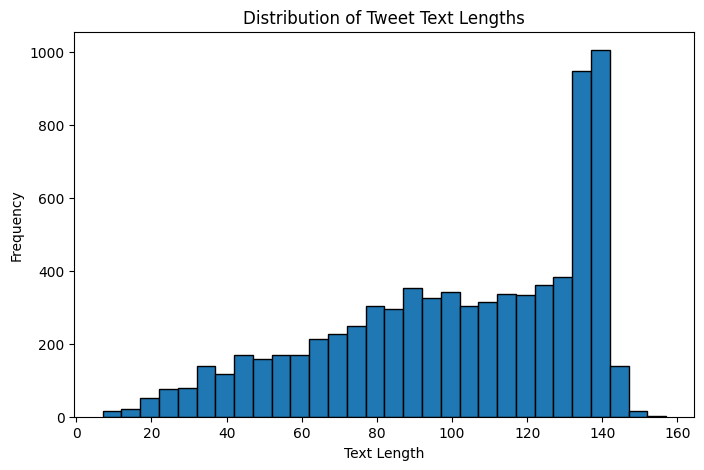

In [17]:
train_data['text_length'] = train_data['text'].apply(len)

plt.figure(figsize=(8, 5))
plt.hist(train_data['text_length'], bins=30, edgecolor='k')
plt.title("Distribution of Tweet Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


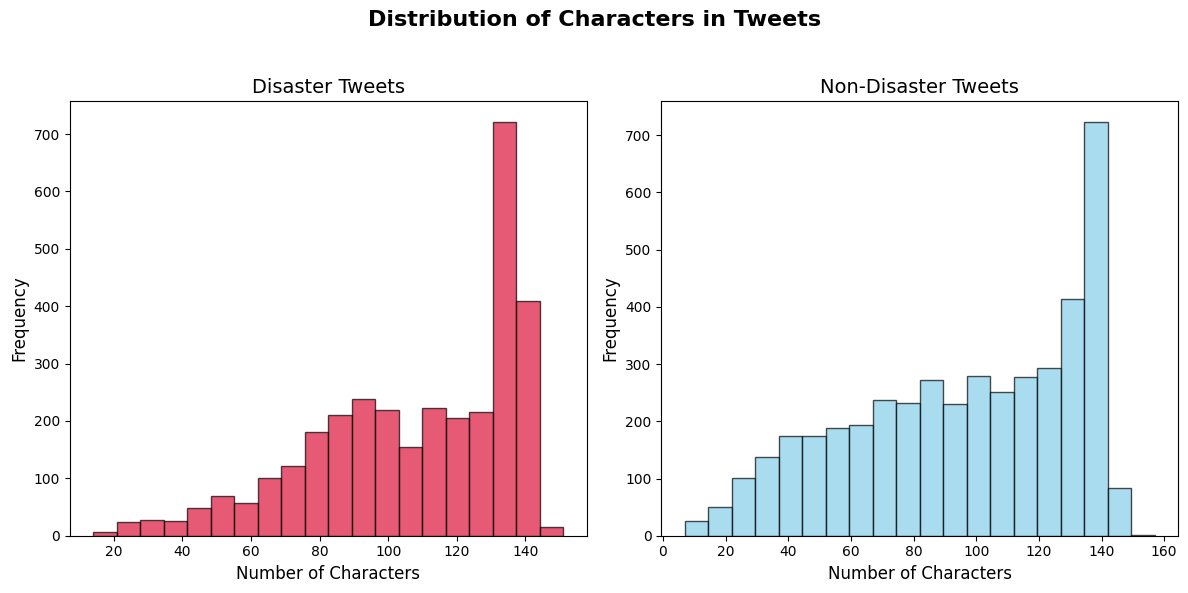

In [ ]:
# Visualizing the number of characters in disaster vs. non-disaster tweets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjusted figure size for better clarity

# Extracting tweet lengths for disaster tweets
disaster_tweet_lengths = train_data[train_data['target'] == 1]['text'].str.len()
ax1.hist(disaster_tweet_lengths, bins=20, color='crimson', edgecolor='black', alpha=0.7)
ax1.set_title('Disaster Tweets', fontsize=14)
ax1.set_xlabel('Number of Characters', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)

# Extracting tweet lengths for non-disaster tweets
non_disaster_tweet_lengths = train_data[train_data['target'] == 0]['text'].str.len()
ax2.hist(non_disaster_tweet_lengths, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_title('Non-Disaster Tweets', fontsize=14)
ax2.set_xlabel('Number of Characters', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)

# Adding a common title for the entire figure
fig.suptitle('Distribution of Characters in Tweets', fontsize=16, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plot
plt.show()

## Data Preprocessing

In [21]:
train_data.drop(['keyword', 'location'], axis=1)
test_data.drop(['keyword', 'location'], axis=1)

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [39]:
# Text preprocessing function
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing whitespace
    return text

## Model Architecture 

The GloVe initialized vectors layer forms an embedding layer which is embedded in the model and is followed by the Bidirectional LSTM layer. The Bidirectional LSTM layer captures information from both past and future time steps, thus providing a deeper understanding of the text sentiment context to the model. This model is built for the purpose of classifying text into two pages, where any tweet pertaining to disaster can be classified into or non-disaster. Our BLSTM which is custom made for us combines LSTM’s ability to work with sequences and which is a huge plus of bidirectional layers. The use of global max pooling and batch normalization makes the model more robust, while the dense layers and dropout layers equip the model with such capability of learning and generalizing complex patterns in the data. In the end, the model itself is aimed at differentiating between such two categories utilizing the sigmoid activation function on the output layer and trained with binary_crossentropy through the rmsprop optimization algorithm.

In [40]:
# Apply text cleaning to the dataset
train_data['cleaned_text'] = train_data['text'].apply(clean_text)

# Tokenization and padding setup
max_words = 20000  # Maximum number of words to keep in tokenizer
max_sequence_length = 100  # Maximum tweet length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['cleaned_text'])



In [43]:
# Tokenize and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_data['cleaned_text'])
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')



In [47]:
# Prepare GloVe embeddings
embedding_dim = 100
embedding_index = {}
with open("glove.6B.100d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefficients

In [48]:
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [52]:
# Build the Bi-LSTM Model
model = Sequential([
    Embedding(num_words, embedding_dim, weights=[embedding_matrix],  trainable=False),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split data into features and labels
X_train = train_padded
y_train = train_data['target']

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split data into features and labels
X_train = train_padded
y_train = train_data['target']

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Save the model for later use
model.save("disaster_tweet_model.h5")

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.6495 - loss: 0.6256 - val_accuracy: 0.7978 - val_loss: 0.4631
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7911 - loss: 0.4828 - val_accuracy: 0.8050 - val_loss: 0.4272
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.8066 - loss: 0.4439 - val_accuracy: 0.8056 - val_loss: 0.4322
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.8094 - loss: 0.4394 - val_accuracy: 0.8129 - val_loss: 0.4150
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8230 - loss: 0.4195 - val_accuracy: 0.8168 - val_loss: 0.4107


In [63]:
# Evaluate the model on validation data
def evaluate_model(model, X_val, y_val):
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    return y_pred

In [56]:
# Preprocess test data
# test_data = pd.read_csv("test.csv")
test_data['cleaned_text'] = test_data['text'].apply(clean_text)
test_sequences = tokenizer.texts_to_sequences(test_data['cleaned_text'])
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')


In [ ]:
# Make predictions on the test set
test_predictions = (model.predict(test_padded) > 0.5).astype("int32")

# Prepare submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'target': test_predictions.flatten()
})
submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")

## Evaluation and Submission

Throughout the epochs, training loss tends to decrease which signifies the model is learning and adjusting itself to make better predictions. On the contrary, after several epochs, validation loss shows a worrying trend, it climbs up after the 5th epoch only to continue wavering around this range for the remaining duration of the training. This proven track record of validation loss increasing whilst training loss continues to decrease beacons a common sign of overfitting. Validation loss increasing points out a concerning fact, that while these models are performing better on their training dataset, it is unable to generalize itself on the validation datasets as was expected. Once the training accuracy hit around 0.95, a destructive trend was observed where the training accuracy begun to level out, hinting at under fitting. Surprisingly, validation accuracy on the other hand, had early peaks of around epoch 3, followed by a decline, moving towards an average of 0.8 across all epochs. With multiple observations showcasing an overwhelming difference between training accuracy and validation accuracy, overfitting becomes the most logical explanation for this difference.

## Conclusion

The major problem with the existing model is overfitting the market risks. The model performs well on the training data but is not able to demonstrate good predictive performance on the validation data set. This is confirmed by the trend of increasing validation loss and decreasing validation accuracy during training.